# Curitiba - Base do 156

Este é um projeto de análise dos dados da base do 156. Consiste em um importador dos dados, um processador, visualizador e, por último exportando os dados em formato Feather.

In [1]:
import qgrid

from pandarallel import pandarallel
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

from curitiba156 import get_downloaded_base156

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Leitura dos dados
Nesse momento os dados são importados por meio da função get_downloaded_base156. Basicamente ele consulta o site do 156, pega o último arquivo CSV e o salva no arquivo `source_data/base_156.csv`. A saída desse comando já entra dentro do pandas por meio do `csv_file` e `encoding`.

In [2]:
csv_file, csv_encoding = get_downloaded_base156()

Fetching latest base of 156...
Latest csv url: http://dadosabertos.c3sl.ufpr.br/curitiba/156/2019-12-01_156_-_Base_de_Dados.csv
File Already exists!
No download needed.
File source_data/base156.csv; Encoding: ISO-8859-1


In [3]:
field_names = ['SOLICITACAO', 'TIPO', 'ORGAO', 'DATA',
               'HORARIO', 'ASSUNTO', 'SUBDIVISAO', 'DESCRICAO',
               'LOGRADOURO_ASS', 'BAIRRO_ASS', 'REGIONAL_ASS',
               'MEIO_RESPOSTA', 'OBSERVACAO', 'SEXO', 'BAIRRO_CIDADAO',
               'REGIONAL_CIDADAO', 'DATA_NASC', 'TIPO_CIDADAO',
               'ORGAO_RESP', 'RESPOSTA_FINAL', 'RESPOSTA_FINAL_DETALHE']

data = pd.read_csv(csv_file, sep=';', encoding=csv_encoding, error_bad_lines=False, skiprows=[0,1], names=field_names)

# Tratamento dos dados
Realizando Tratamento dos dados no dataset. Nesse local será feito limpeza, assim como criação de novos datasets, à partir do primeiro dataset.

In [4]:
# Processando data como tipo Datetime
data['DATA'] = data['DATA'].str.strip()
data['DATA'] = data.parallel_apply(lambda x: datetime.strptime(x['DATA'], '%d/%m/%Y') if type(x['DATA']) is str else None, axis=1)


# Exibição dos dados
O grid a ser exibido usa o QGrid. Ele funciona como uma espécie de Excel.

In [5]:
qgrid.show_grid(data)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [6]:
data_orgaos = data[['ORGAO']].groupby(['ORGAO']).size().reset_index(name='counts').sort_values(['counts'], ascending=False)
qgrid.show_grid(data_orgaos)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

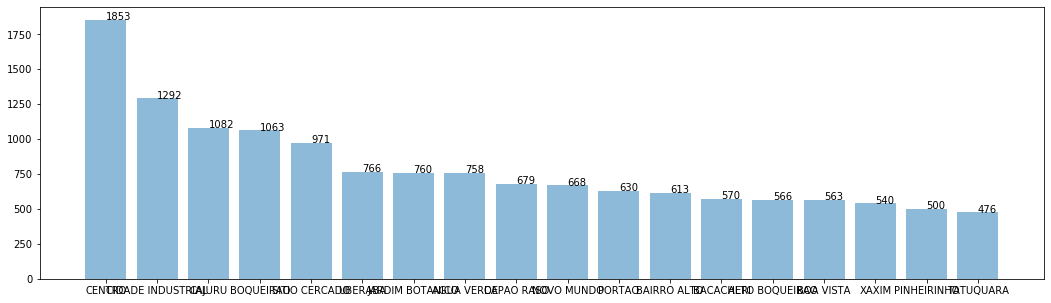

In [7]:
data_top_bairros = data.groupby('BAIRRO_ASS')['BAIRRO_ASS'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(18)

plt.figure(figsize=(18,5))
plt.bar(data_top_bairros['BAIRRO_ASS'], data_top_bairros['count'], align='center', alpha=0.5)

for a,b in zip(data_top_bairros['BAIRRO_ASS'], data_top_bairros['count']):
    plt.text(a, b, str(b))

plt.show()

# Exportando dados
Todas as bases de dados podem ser exportadas para o formato Feather. Este formato é o mais rápido e será exportado no Github por meio de ferramenta de de Integraçao/Delivery Contínuo.

In [10]:
data.to_feather(fname='clean_data/data_156.feather')
data_top_bairros.reset_index().to_feather(fname='clean_data/data_top_bairros.feather')
